In [1]:
from scipy import ndimage
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
data_path = './data/data/IMG/'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
lines = []
with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        lines.append(line)

index = 10
print('Total number of lines: {}'.format(len(lines)))
print('Line example: {}'.format(lines[index]))

Total number of lines: 8036
Line example: ['IMG/center_2016_12_01_13_31_13_786.jpg', ' IMG/left_2016_12_01_13_31_13_786.jpg', ' IMG/right_2016_12_01_13_31_13_786.jpg', ' 0', ' 0', ' 0', ' 1.334892']


In [5]:
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [50]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        samples = shuffle(samples)
        for offset in range (0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                filename = batch_sample[0].split('/')[-1]
                center_image = cv2.imread(data_path + filename) #TODO this is in format BGR
                resize = (200, 66)
                center_image = cv2.resize(center_image, resize, interpolation=cv2.INTER_AREA)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2YUV)                                
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
            
            X_data = np.array(images)
            y_data = np.array(angles)
            yield shuffle(X_data, y_data)

# TODO add left and right camera images and angles, convert images to YUV

In [51]:
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

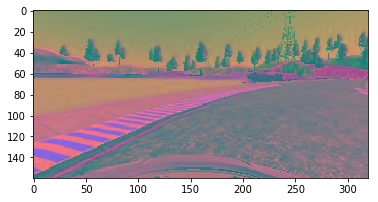

In [8]:
# img = cv2.imread('./data/data/IMG/center_2016_12_01_13_31_13_786.jpg')
img = cv2.imread('driving_side1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

cv2.imwrite('yuv_image2.png', img)
plt.imshow(img)

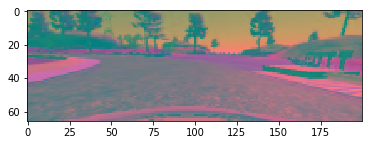

In [32]:
img = cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)
plt.imshow(img)

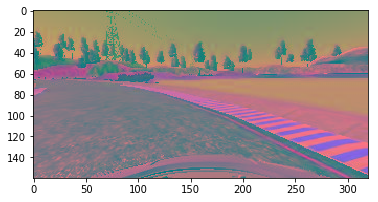

In [9]:
img = np.fliplr(img)
cv2.imwrite('flipped_image2.png', img)
plt.imshow(img)

In [33]:
input_shape = (66, 200, 3)

In [34]:
# CNN architecture

model = Sequential()
# model.add(Cropping2D(cropping=((25, 8), (0, 0)), input_shape=input_shape))
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=input_shape))
model.add(Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(filters=36, kernel_size=(5, 5), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(filters=48, kernel_size=(5, 5), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

In [39]:
model.compile(optimizer='adam', loss='mse')

In [ ]:

history_obj = model.fit_generator(train_generator, steps_per_epoch=len(train_samples), validation_data=validation_generator, validation_steps=len(validation_samples), epochs=3, verbose=1)

Epoch 1/3
6428/6428 [==============================] - 2121s 330ms/step - loss: 0.0038 - val_loss: 0.0099
Epoch 2/3
6428/6428 [==============================] - 1959s 305ms/step - loss: 4.8876e-04 - val_loss: 0.0093
Epoch 3/3
4483/6428 [===================>..........] - ETA: 8:22 - loss: 3.6876e-04

In [ ]:
model.save('model/model.h5')

In [8]:
# images = []
# meassurements = []
# for line in lines:
#     for i in range(3):
#         source_path = line[i]
#         filename = source_path.split('/')[-1]
#         current_path = './data/data/IMG/' + filename
#         image = ndimage.imread(current_path)
#         images.append(image)
#         meassurement = float(line[i + 3])
#         meassurements.append(meassurement)
        
# print('images and meassurements extracted')
# print('images shape: '.format(len(images)))
# print('meassurements shape: '.format(len(meassurements)))        

/home/deyber/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


images and meassurements extracted
images shape: 
meassurements shape: 


In [9]:
# augmented_images, augmented_meassurements = [], []
# for image, meassurement in zip(images, meassurements):
#     augmented_images.append(image)
#     augmented_meassurements.append(meassurement)
#     augmented_images.append(cv2.flip(image, 1))
#     augmented_meassurements.append(meassurement * -1.0)